<a href="https://colab.research.google.com/github/Wentemi/ESG-Co-Occurrence-Network/blob/main/_ESG_Co_occurrence_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
#@title Install and load all the necessary libraries
!pip3 install pyvis snscrape datapane
import datapane as dp
import re
import pandas as pd
import seaborn as sns
import itertools
from IPython.core.display import display, HTML
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import networkx as nx
from pyvis.network import Network
import community
import community as community_louvain
import operator
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import PorterStemmer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [35]:
#@title Scrape a total of 150k #ESG Twitters
import snscrape.modules.twitter as sntwitter
df = pd.DataFrame(itertools.islice(sntwitter.TwitterSearchScraper('#ESG since:2022-07-31 until:2023-03-31 lang:en').get_items(),150000))
tweet_df=df[['date','rawContent','hashtags','cashtags']]

#tweet_df.to_csv('/content/drive/MyDrive/NLP/NDC/ESG_testK.csv')

In [36]:
#@title Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')
df=pd.read_csv('/content/drive/MyDrive/NLP/NDC/ESG_testK.csv', sep=',',index_col=False, dtype='unicode')
tweet_df=df.drop_duplicates(subset=["rawContent"], keep=False).reset_index()
tweet_df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,index,Unnamed: 0,date,rawContent,hashtags,cashtags
0,0,0,2023-03-30 23:57:03+00:00,New Climate News: \n\nCorporate Interests ‘Wat...,"['climatecrisis', 'climateaction', 'esg', 'car...",NaN
1,1,1,2023-03-30 23:55:53+00:00,"Hey @GOP, if you think that #ESG is going away...",['ESG'],NaN
2,2,2,2023-03-30 23:54:35+00:00,"At Seagate, we’re driven by a sustainable data...","['Sustainability', 'Inclusivity', 'Governance'...",NaN
3,3,3,2023-03-30 23:42:01+00:00,Read how AI and blockchain can create innovati...,"['ai', 'blockchain', 'ESG']",NaN
4,4,4,2023-03-30 23:40:39+00:00,"**The cure must not be worse than the disease,...","['EVs', 'youth4climate', 'ESGscam', 'ESG', 'Ca...",NaN
...,...,...,...,...,...,...
145009,5815628,149423,2022-07-31 00:38:58+00:00,Wonder where Food Inflation comes from?\n\nAns...,"['ESG', 'WEF']",NaN
145010,5815629,149424,2022-07-31 00:25:12+00:00,#ESG Twitter 😩💦 https://t.co/8JRnNnQWMy,['ESG'],NaN
145011,5815630,149425,2022-07-31 00:24:03+00:00,How do Top 7-Figure Entrepreneurs thrive? Get ...,['esg'],NaN
145012,5815631,149426,2022-07-31 00:19:29+00:00,#Fisker Ocean Headed to Pebble Beach $FSR http...,"['Fisker', 'esg', 'climateaction', 'electricve...",['FSR']


In [42]:
#@title Loading all the neccessary functions
def clean_hashtags(tweet):
  tweet=str(tweet)
  tweet = re.sub(r"[^\w\s]", "", tweet) # Remove punctuation
  #tweet = re.sub(r"\d+", "", tweet) # Remove numbers
  tweet = tweet.lower() # Convert to lowercase
  tweet = re.sub(r"\s+", " ", tweet).strip() # Remove extra whitespace
  tweet_list = []
  stop_words = nltk.corpus.stopwords.words('english')
  stop_words.extend(['esg','amp'])
  for token in re.split('\W+', tweet):
        if token not in stop_words :  
            tweet_list.append(PorterStemmer().stem(token))
            #tweet_list.append(token)
  return tweet_list

def pair_words(tweet):
  word_list=tweet.tolist()
  pair_words = []
  for words in word_list:
    words_ = list(set(words))
    for i in range(len(words_)-1):
        for j in range(i+1, len(words_)):
            word_i = words_[i]
            word_j = words_[j]
            if word_i < word_j:
                pair_words.append([word_i, word_j])
            else:
                pair_words.append([word_i, word_j])
    
  pair_words_df = pd.DataFrame(data = pair_words, columns=['Source', 'Target'])
  pair_words_df = pair_words_df.groupby(['Source','Target']).size().sort_values().reset_index()
  pair_words_df=pair_words_df.rename(columns={0:'Weight'})
  return pair_words_df
from pyvis.network import Network
import networkx as nx
import community
from community import community_louvain
def community_network_viz(df,K):
  df=df.loc[df['Weight']>K]
  min_=min(df['Weight'])
  max_=max(df['Weight'])
  G = nx.from_pandas_edgelist(df, source = "Source", target = "Target",edge_attr = "Weight",create_using = nx.Graph())
  partition=community_louvain.best_partition(G)
  nx.set_node_attributes(G, partition,'group')
  for _, row in df.iterrows():
    G.add_edge(row['Source'], row['Target'], weight=row['Weight']/max_)
    d = dict(G.degree)
    d.update((x, 1*y) for x, y in d.items())
  #Setting up size attribute
  nx.set_node_attributes(G,d,'size')
  net_com  = Network(height="600px",
             width="75%",
             directed=False,
             notebook=True,
             neighborhood_highlight=True,
             select_menu=True,
             bgcolor="#36454F",
             font_color='white',
             layout=None,
             #heading="Pairing of ESG Hashtags",
             cdn_resources="remote")
  net_com.repulsion()
  #net_com.barnes_hut(central_gravity=0.15,
                         #node_distance=420,
                         #spring_length=100,
                         #spring_strength=0.15,
                         #damping=0.96)
  net_com.set_options("""var options = {"edges": {"color": {"inherit": true},"font": {"size": 50,"strokeWidth": 3},"scaling": {"max": 14},"smooth": false},"interaction": {"tooltipDelay": 100}}""")
  net_com.from_nx(G, )
  net_com.save_graph('/content/drive/MyDrive/NLP/ESG_com.html')
  net_com.show('/content/drive/MyDrive/NLP/ESG_com.html')
  return display(HTML('/content/drive/MyDrive/NLP/ESG_com.html'))

In [25]:
#@title Cleaning the hashtags 
tweet_df['clean_hashtags']=tweet_df.hashtags.apply(clean_hashtags)

In [26]:
#@title Mapping and aggregating the co-occuring hashtags
pair_word_tweet=pair_words(tweet_df.clean_hashtags)
pair_word_tweet.head()

,Source,Target,Weight
0,0trust,afford,1
1,marxism,ngo,1
2,marxism,netzero,1
3,marxism,msm,1
4,marxism,marxist,1


In [27]:
#@title Exploring the features of the network of paired hashtags
G = nx.from_pandas_edgelist(pair_word_tweet, source = "Source", target = "Target",edge_attr = "Weight",create_using = nx.Graph())
G.name = 'Network of ESG Tweets'
print(G)

Graph named 'Network of ESG Tweets' with 36453 nodes and 361749 edges


In [28]:
density = nx.density(G)
print("Network density:", density)

Network density: 0.0005444809603158933


[Text(0, 0.5, ''), Text(0.5, 0, 'Degree Centrality')]

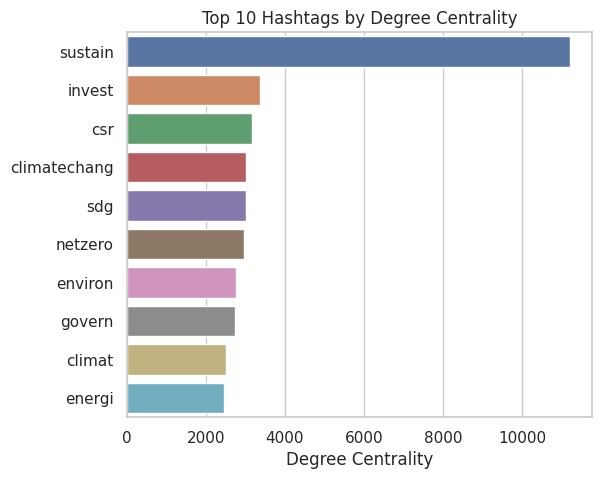

In [29]:

sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(6, 5))
from operator import itemgetter
degree_dict = dict(G.degree(G.nodes()))
nx.set_node_attributes(G, degree_dict, 'degree')
top10_degree = dict(sorted(degree_dict.items(), key=itemgetter(1), reverse=True)[:10])
sns.barplot(y = list(top10_degree .keys()), x = list(top10_degree .values())).set(title='Top 10 Hashtags by Degree Centrality')
ax.set(ylabel="",xlabel="Degree Centrality")

In [43]:
community_network_viz(pair_word_tweet,200)

/content/drive/MyDrive/NLP/ESG_com.html


In [44]:
dp.login(token="b286c1c29240639a607294ef3267bba0f287701c")
with open('/content/drive/MyDrive/NLP/ESG_com.html', 'r') as f:
    ESG_com = f.read()
dp.upload_report([dp.View(dp.HTML(ESG_com))],name="ESG Tweets", open=True, visibility='PUBLIC')

Connected successfully to https://cloud.datapane.com as raphael.apeaning@stonybrook.edu


Uploading report and associated data - *please wait...*

Report successfully uploaded - view and share at <a href='https://cloud.datapane.com/reports/n3ZxDGk/esg-tweets/' target='_blank'>here</a>.

Uploaded CloudReport - view at https://cloud.datapane.com/reports/n3ZxDGk/esg-tweets/